In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

In [2]:
df = pd.read_csv('transactions-2023-01-11.csv')

In [3]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Registration type", "Master Project"])
    # Drop leaky columns
    data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller"])
    return data


In [4]:
df = drop_excess_columns(df)

In [5]:
def get_oil_price():
    # data from https://tradingeconomics.com/commodity/crude-oil
    r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1d&span=5y&securify=new&url=/commodity/crude-oil&AUTH=Q8lxP7S8XEYlloC%2FSMr0eTGbD53NoztMkkM1MDEJCyQhuim5sw4GTlleWJqfGRet&ohlc=0')
    
    oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "Oil Price"})
    oil_data = oil_data[(oil_data['date'] > '2021-03-01') & (oil_data['date'] < '2022-02-04')]

    return oil_data[['date', 'Oil Price']]
    

In [6]:
oil_data = get_oil_price()
oil_data

,date,Oil Price
864,2021-03-01T00:00:00,60.64
865,2021-03-02T00:00:00,59.75
866,2021-03-03T00:00:00,61.28
867,2021-03-04T00:00:00,63.83
868,2021-03-05T00:00:00,66.09
...,...,...
1100,2022-01-28T00:00:00,85.43
1101,2022-01-31T00:00:00,86.49
1102,2022-02-01T00:00:00,86.46
1103,2022-02-02T00:00:00,86.69


In [7]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [8]:
df = drop_period_after_war(df)

In [9]:
def merge_oil_to_data(data, oil):
    data['date_without_time'] = pd.to_datetime(data['Transaction Date']).dt.strftime('%Y-%m-%d')
    oil['date_without_time'] = pd.to_datetime(oil['date']).dt.strftime('%Y-%m-%d')
    data = data.merge(oil, left_on='date_without_time', right_on='date_without_time')
    return data

In [10]:
df = merge_oil_to_data(df, oil_data)

In [11]:
df

,Transaction Date,Transaction Type,Is Free Hold?,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,Nearest Mall,Nearest Landmark,date_without_time,date,Oil Price
0,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,138.93,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
1,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,87.26,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
2,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,76.13,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
3,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,130.05,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
4,2021-03-02 13:53:10,Mortgage,Free Hold,Residential,AL BARARI,Flat,1435909.09,52.15,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69700,2021-07-23 03:41:08,Mortgage,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,888655.00,106.55,Dubai Internet City,Mall of the Emirates,Sports City Swimming Academy,2021-07-23,2021-07-23T00:00:00,72.07
69701,2021-07-30 01:08:56,Mortgage,Free Hold,Residential,ARABIAN RANCHES II,Residential,3283133.00,836.75,NaN,NaN,Motor City,2021-07-30,2021-07-30T00:00:00,73.95
69702,2021-07-30 01:42:39,Mortgage,Non Free Hold,Residential,Nad Al Shiba Third,NaN,2270000.00,468.74,Creek Metro Station,City Centre Mirdif,NaN,2021-07-30,2021-07-30T00:00:00,73.95
69703,2021-07-30 01:44:58,Mortgage,Non Free Hold,Residential,Nad Al Shiba Third,NaN,2155300.00,469.30,Creek Metro Station,City Centre Mirdif,NaN,2021-07-30,2021-07-30T00:00:00,73.95


In [34]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.98)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    data = data[data['Property Sub Type'].isin(["Commercial", "Flat", "Hotel Apartment", "Hotel Rooms",  "Office", "Residential", "Residential / Attached Villas","Residential Flats", "Stacked Townhouses", "Villa"])]
    data = data.dropna()
    return data

In [35]:
cleaned_df = clean_outliers_in_data(df)

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_1363/708482841.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.98)


In [36]:
cleaned_df

,Transaction Date,Transaction Type,Is Free Hold?,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,Nearest Mall,Nearest Landmark,date_without_time,date,Oil Price
119,2021-03-02 08:12:18,Sales,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,605350.0,60.81,Nakheel Metro Station,Marina Mall,Sports City Swimming Academy,2021-03-02,2021-03-02T00:00:00,59.75
120,2021-03-02 08:12:26,Sales,Free Hold,Residential,BURJ KHALIFA,Flat,2244888.0,98.61,Buj Khalifa Dubai Mall Metro Station,Dubai Mall,Burj Khalifa,2021-03-02,2021-03-02T00:00:00,59.75
121,2021-03-02 08:12:43,Sales,Free Hold,Residential,DUBAI MARINA,Hotel Rooms,639275.0,7.87,Mina Seyahi,Marina Mall,Burj Al Arab,2021-03-02,2021-03-02T00:00:00,59.75
122,2021-03-02 08:14:30,Sales,Free Hold,Residential,DUBAI HILLS,Villa,3070875.0,268.80,Noor Bank Metro Station,Mall of the Emirates,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
123,2021-03-02 08:14:39,Sales,Free Hold,Residential,PALM JUMEIRAH,Hotel Apartment,1160111.0,66.19,Palm Jumeirah,Marina Mall,Burj Al Arab,2021-03-02,2021-03-02T00:00:00,59.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69697,2021-07-23 02:46:49,Mortgage,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Hotel Rooms,262500.0,44.90,Nakheel Metro Station,Marina Mall,Sports City Swimming Academy,2021-07-23,2021-07-23T00:00:00,72.07
69698,2021-07-23 02:49:20,Mortgage,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Hotel Rooms,262500.0,44.91,Nakheel Metro Station,Marina Mall,Sports City Swimming Academy,2021-07-23,2021-07-23T00:00:00,72.07
69699,2021-07-23 03:05:48,Mortgage,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,628000.0,94.02,Dubai Internet City,Mall of the Emirates,Sports City Swimming Academy,2021-07-23,2021-07-23T00:00:00,72.07
69700,2021-07-23 03:41:08,Mortgage,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,888655.0,106.55,Dubai Internet City,Mall of the Emirates,Sports City Swimming Academy,2021-07-23,2021-07-23T00:00:00,72.07


In [37]:
from pandas.plotting import scatter_matrix

def plot_matrix(data):
    scatter_matrix(data[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))
    scatter_matrix(data[['Amount', 'Oil Price']], figsize=(12, 8))
    return data['Property Size (sq.m)'].describe()

count    43595.000000
mean       179.171362
std        220.355850
min          7.300000
25%         69.380000
50%        107.490000
75%        180.000000
max       1732.500000
Name: Property Size (sq.m), dtype: float64

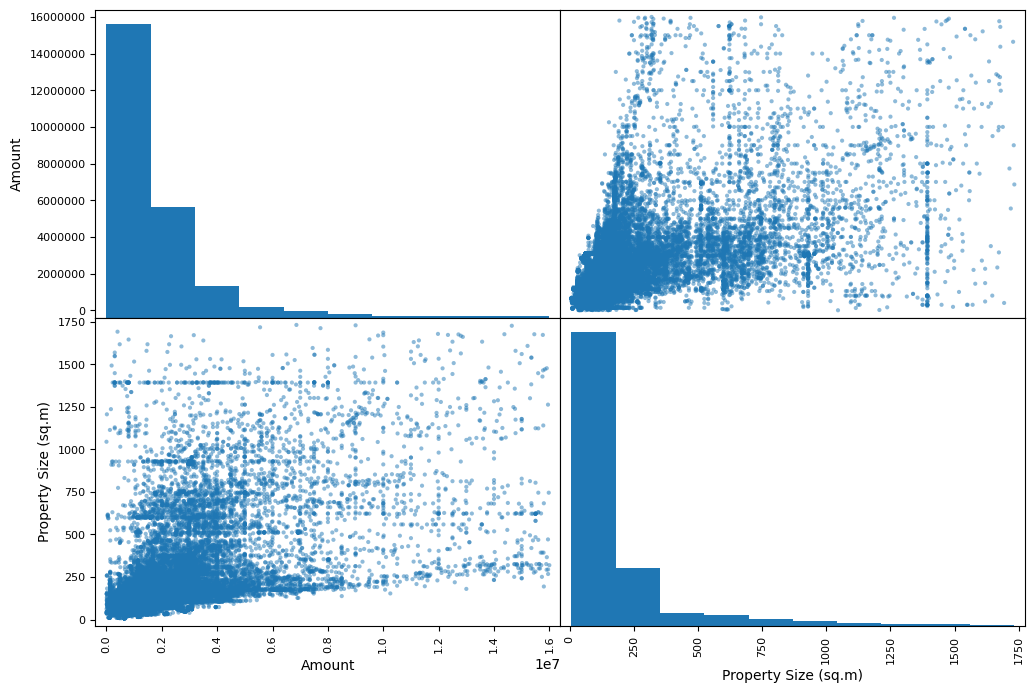

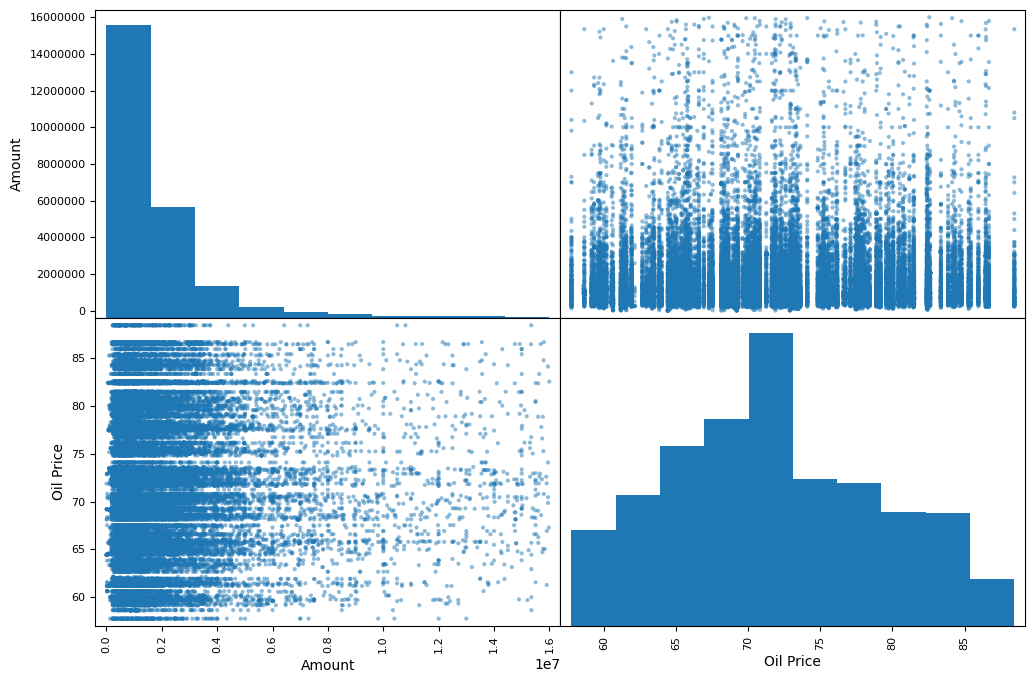

In [38]:
plot_matrix(cleaned_df)

In [39]:
def preparing_data_before_training(data, drop, renameColumns):
    data = data.drop(drop, axis=1)
    data = data.rename(columns=renameColumns)
    return data

In [40]:
prepared_data = preparing_data_before_training(
    cleaned_df, 
    ['date_without_time', 'Transaction Date', 'date'],
    {
        'Property Size (sq.m)': 'Property_Size',
        'Property Sub Type': 'Property_Sub_Type',
        'Nearest Metro': 'Nearest_Metro',
        'Nearest Mall': 'Nearest_Mall',
        'Nearest Landmark': 'Nearest_Landmark',
        'Oil Price': 'Oil_Price',
        'Transaction Type': 'Transaction_Type',
        "Is Free Hold?": 'Is_Free_Hold'
    }
)

In [42]:
import statsmodels.formula.api as smf

sm_data = sm.add_constant(prepared_data)
model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + C(Is_Free_Hold)', data=sm_data)
results = model.fit()


In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     425.4
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:54:08   Log-Likelihood:            -6.6980e+05
No. Observations:               43595   AIC:                         1.340e+06
Df Residuals:                   43392   BIC:                         1.342e+06
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                 4.759e+06   4.07e+05     11.706      0.000    3.96e+06    5.56e+06
C(Transaction_Type)[T.Mortgage]                          -1.533e+05    2.9e+04     -5.283      0.000    -2.1e+05   -9.64e+04
C(Transaction_Type)[T.Sales]                              5.483e+05   2.77e+04     19.799      0.000    4.94e+05    6.03e+05
C(Usage)[T.Residential]                                  -6.909e+04   4.16e+04     -1.662      0.097   -1.51e+05    1.24e+04
C(Area)[T.AL KHAIL HEIGHTS]                              -1.166e+06   2.25e+05     -5.180      0.000   -1.61e+06   -7.25e+05
C(Area)[T.ARABIAN RANCHES I]                             -9.668e+05   1.34e+05     -7.201      0.000   -1.23e+06   -7.04e+05
C(Area)[T.ARJAN]                                          2.387e+05   1.03e+05      2.309      0.021    3.61e+04    4.41e+05
C(Area)[T.Al Bada]                                       -6.247e+05    4.5e+05     -1.387      0.165   -1.51e+06    2.58e+05
C(Area)[T.Al Baraha]                                     -2.792e+05    6.3e+05     -0.443      0.658   -1.51e+06    9.56e+05
C(Area)[T.Al Barsha First]                                6.139e+05   4.09e+05      1.500      0.134   -1.88e+05    1.42e+06
C(Area)[T.Al Barsha Second]                              -3.106e+06   2.62e+05    -11.853      0.000   -3.62e+06   -2.59e+06
C(Area)[T.Al Barsha Third]                               -2.593e+06   2.55e+05    -10.154      0.000   -3.09e+06   -2.09e+06
C(Area)[T.Al Barshaa South First]                        -2.707e+06   4.47e+05     -6.056      0.000   -3.58e+06   -1.83e+06
C(Area)[T.Al Barshaa South Third]                        -2.059e+05   6.53e+05     -0.315      0.753   -1.49e+06    1.07e+06
C(Area)[T.Al Dhagaya]                                    -5.645e+06    8.6e+05     -6.560      0.000   -7.33e+06   -3.96e+06
C(Area)[T.Al Garhoud]                                     1.554e+06   5.08e+05      3.058      0.002    5.58e+05    2.55e+06
C(Area)[T.Al Goze First]                                 -2.787e+06      3e+05     -9.277      0.000   -3.38e+06    -2.2e+06
C(Area)[T.Al Goze Fourth]                                -1.095e+06   8.18e+05     -1.338      0.181    -2.7e+06    5.09e+05
C(Area)[T.Al Goze Second]                                -4.904e+06   6.73e+05     -7.281      0.000   -6.22e+06   -3.58e+06
C(Area)[T.Al Hamriya]                                     9.148e+06   1.19e+06      7.685      0.000    6.82e+06    1.15e+07
C(Area)[T.Al Hudaiba]                                    -7.512e+06    1.1e+06     -6.806      0.000   -9.68e+06   -5.35e+06
C(Area)[T.Al Jafliya]                                     1.247e+05   1.59e+06     

eval_env: 1


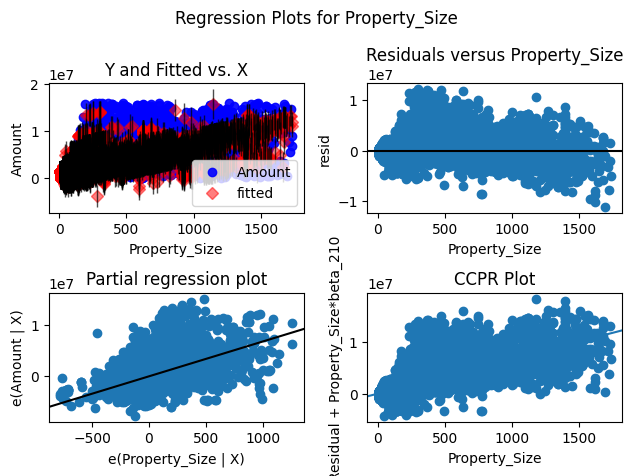

In [44]:
fig = sm.graphics.plot_regress_exog(results, "Property_Size")
fig.tight_layout(pad=1.0)

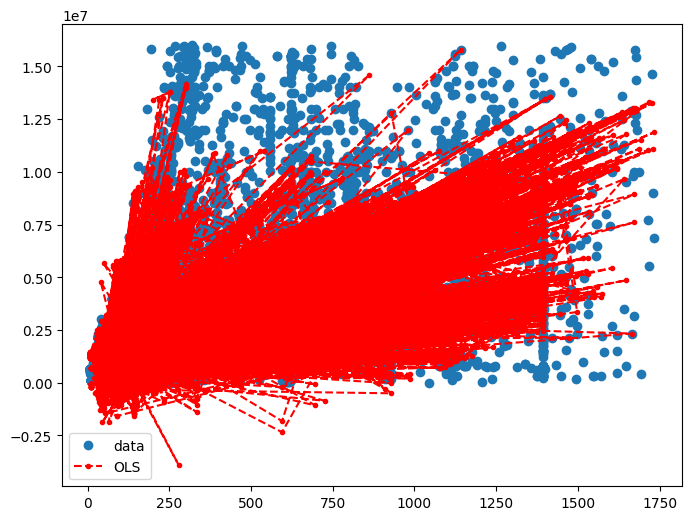

In [50]:
pred_ols = results.get_prediction()

fig, ax = plt.subplots(figsize=(8, 6))

x = prepared_data['Property_Size']
y = prepared_data['Amount']

ax.plot(x, y, "o", label="data")
ax.plot(x, results.fittedvalues, "r--.", label="OLS")

ax.legend(loc="best")

In [48]:
range(len(x))

range(0, 43595)

In [ ]:
iv_u

In [33]:
results.fittedvalues

119      6.543251e+05
120      2.875025e+06
121      1.177527e+06
122      3.452304e+06
123      2.182871e+06
             ...     
69697    5.363757e+05
69698    5.364432e+05
69699   -1.641469e+05
69700   -7.959048e+04
69704    1.898450e+06
Length: 43595, dtype: float64

In [26]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_c